# A journey through Natural Language Processing

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
import scipy
from sklearn.decomposition import LatentDirichletAllocation
import random
from string import punctuation
from wordcloud import STOPWORDS
from statistics import mean

## Import Data

In [2]:
df = pd.read_csv('fake_or_real_news.csv')

In [8]:
# We create a test data that we will just use for the final predictions
df_train = df.sample(frac=0.9, random_state=42)
df_test = df.drop(df_train.index)

In [9]:
print(f'Train Data Shape: {df_train.shape}')
print(f'Test Data Shape: {df_test.shape}')

Train Data Shape: (5702, 4)
Test Data Shape: (633, 4)


In [10]:
display(df_train.head())

,Unnamed: 0,title,text,label
1357,9957,"American Dream, Revisited",Will Trump pull a Brexit times ten? What would...,FAKE
2080,7596,Clintons Are Under Multiple FBI Investigations...,Clintons Are Under Multiple FBI Investigations...,FAKE
2718,8905,The FBI Can’t Actually Investigate a Candidate...,Dispatches from Eric Zuesse This piece is cros...,FAKE
812,8752,Confirmed: Public overwhelmingly (10-to-1) say...,Print \n[Ed. – Every now and then the facade c...,FAKE
4886,7804,Nanny In Jail After Force Feeding Baby To Death,Nanny In Jail After Force Feeding Baby To Deat...,FAKE


In [11]:
display(df_train.shape)

(5702, 4)

In [12]:
# Check for duplicates
len(df_train[df_train.duplicated()])

0

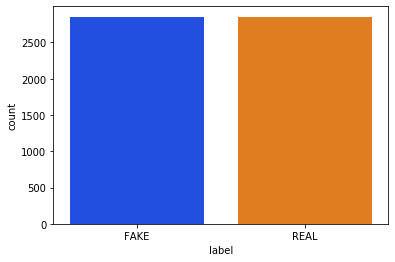

In [13]:
# Plot the distribution of the target variable
sns.countplot(x='label', data=df_train, palette='bright')
plt.show()

In [14]:
# There is almost the same number of real and fake news
df_train.label.value_counts()

FAKE    2855
REAL    2847
Name: label, dtype: int64

# Feature engineering with meta-features

## Adding the number of characters

In [15]:
# We add a new column containing the length of each text (number of character)
df_train['char_count'] = df_train.text.apply(lambda x: len(x))

In [16]:
df_train['char_count'].describe()

count      5702.000000
mean       4705.494739
std        4990.421606
min           1.000000
25%        1738.250000
50%        3624.500000
75%        6204.000000
max      115372.000000
Name: char_count, dtype: float64

In [17]:
# There are 28 empty texts
len(df_train[df_train['char_count'] == 1])

28

In [18]:
# The 28 empty texts are labeled as 'FAKE'
df_train.label[df_train['char_count'] == 1].unique()

array(['FAKE'], dtype=object)

In [19]:
# What are the indexes of these empty texts ?
blanks = []

for i, text, label in df_train[['text', 'label']].itertuples():
    if type(text) == str:
        if text.isspace():
            blanks.append(i)

print(f'There are {len(blanks)} empty texts: {blanks}')

There are 28 empty texts: [1941, 4253, 3350, 4713, 2662, 1883, 710, 3641, 106, 2576, 5213, 5017, 2244, 1736, 2788, 5639, 6064, 2426, 1851, 6328, 940, 5772, 806, 3511, 6175, 3642, 919, 2832]


In [20]:
# We drop these 28 empty texts
df_train.drop(blanks, axis=0, inplace=True)

In [21]:
df_train.shape

(5674, 5)

## Adding the number of punctuation

In [22]:
# We add a new column with the number of punctuation within each text
df_train['punct_count'] = df_train.text.apply(lambda x: len([i for i in x if i in punctuation]))

In [23]:
df_train['punct_count'].describe()

count    5674.000000
mean      116.181177
std       127.088373
min         0.000000
25%        40.000000
50%        89.000000
75%       150.000000
max      2620.000000
Name: punct_count, dtype: float64

## Adding the number of words

In [24]:
df_train['word_count'] = df_train.text.apply(lambda x: len(x.split()))

In [25]:
df_train['word_count'].describe()

count     5674.000000
mean       779.501234
std        836.026773
min          1.000000
25%        293.000000
50%        598.000000
75%       1026.000000
max      20891.000000
Name: word_count, dtype: float64

## Adding the number of unique words

In [246]:
df_train['unique_word_count'] = df_train.text.apply(lambda x: len(set(x.split())))

In [247]:
df_train['unique_word_count'].describe()

count    5674.000000
mean      403.120902
std       327.801581
min         1.000000
25%       190.000000
50%       346.000000
75%       537.000000
max      5237.000000
Name: unique_word_count, dtype: float64

## Adding the number of stopwords

In [248]:
df_train['stop_word_count'] = df_train.text.apply(lambda x: len([w for w in x.lower().split() if w in STOPWORDS]))

In [249]:
df_train['stop_word_count'].describe()

count    5674.000000
mean      324.719951
std       363.820002
min         0.000000
25%       116.000000
50%       245.000000
75%       432.000000
max      9945.000000
Name: stop_word_count, dtype: float64

## Adding the mean word length

In [250]:
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [251]:
df_train['mean_word_length'].describe() # pourquoi 48 ? (mots collées avec /)

count    5674.000000
mean        5.085153
std         0.737586
min         3.714286
25%         4.881296
50%         5.050950
75%         5.225621
max        48.496000
Name: mean_word_length, dtype: float64

## Adding the number of url

In [252]:
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

In [253]:
df_train['url_count'].describe()

count    5674.000000
mean        0.109623
std         0.918100
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        31.000000
Name: url_count, dtype: float64

## Adding the number of hashtag &#35;

In [254]:
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

In [255]:
df_train['hashtag_count'].describe()

count    5674.000000
mean        0.115086
std         0.986052
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        42.000000
Name: hashtag_count, dtype: float64

## Adding the number of mention @

In [256]:
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [257]:
df_train['mention_count'].describe()

count    5674.000000
mean        0.225943
std         2.112404
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       131.000000
Name: mention_count, dtype: float64

In [258]:
def preprocess(df):
    df['char_count'] = df.text.apply(lambda x: len(x))
    df['punct_count'] = df.text.apply(lambda x: len([i for i in x if i in punctuation]))
    df['word_count'] = df.text.apply(lambda x: len(x.split()))
    df['unique_word_count'] = df.text.apply(lambda x: len(set(x.split())))
    df['stop_word_count'] = df.text.apply(lambda x: len([w for w in x.lower().split() if w in STOPWORDS]))
    df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
    df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
    df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

# Exploratory Data Analysis

## Numerical Features

### char_count

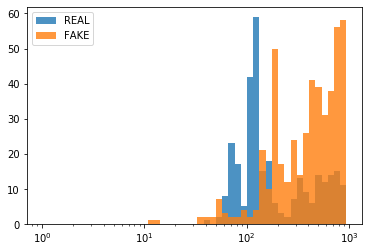

In [259]:
plt.xscale('log')
bins = 1.15**(np.arange(0,50))
plt.hist(df_train[df_train['label']=='REAL']['char_count'],bins=bins,alpha=0.8)
plt.hist(df_train[df_train['label']=='FAKE']['char_count'],bins=bins,alpha=0.8)
plt.legend(('REAL','FAKE'))
plt.show()

### punct_count

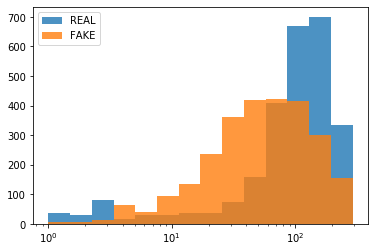

In [260]:
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(df_train[df_train['label']=='REAL']['punct_count'],bins=bins,alpha=0.8)
plt.hist(df_train[df_train['label']=='FAKE']['punct_count'],bins=bins,alpha=0.8)
plt.legend(('REAL','FAKE'))
plt.show()

### word_count

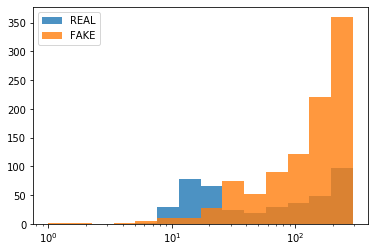

In [261]:
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(df_train[df_train['label']=='REAL']['word_count'],bins=bins,alpha=0.8)
plt.hist(df_train[df_train['label']=='FAKE']['word_count'],bins=bins,alpha=0.8)
plt.legend(('REAL','FAKE'))
plt.show()

### unique_word_count

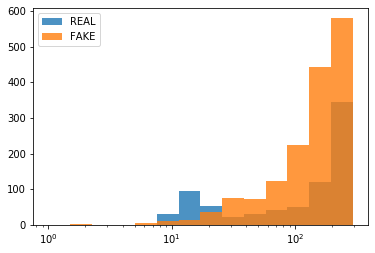

In [262]:
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(df_train[df_train['label']=='REAL']['unique_word_count'],bins=bins,alpha=0.8)
plt.hist(df_train[df_train['label']=='FAKE']['unique_word_count'],bins=bins,alpha=0.8)
plt.legend(('REAL','FAKE'))
plt.show()

### stop_word_count

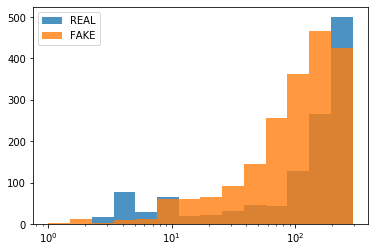

In [263]:
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(df_train[df_train['label']=='REAL']['stop_word_count'],bins=bins,alpha=0.8)
plt.hist(df_train[df_train['label']=='FAKE']['stop_word_count'],bins=bins,alpha=0.8)
plt.legend(('REAL','FAKE'))
plt.show()

### mean_word_length

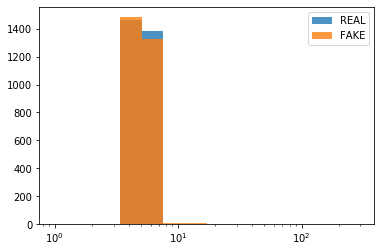

In [264]:
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(df_train[df_train['label']=='REAL']['mean_word_length'],bins=bins,alpha=0.8)
plt.hist(df_train[df_train['label']=='FAKE']['mean_word_length'],bins=bins,alpha=0.8)
plt.legend(('REAL','FAKE'))
plt.show()

### url_count

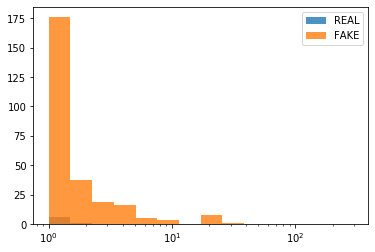

In [265]:
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(df_train[df_train['label']=='REAL']['url_count'],bins=bins,alpha=0.8)
plt.hist(df_train[df_train['label']=='FAKE']['url_count'],bins=bins,alpha=0.8)
plt.legend(('REAL','FAKE'))
plt.show()

### hashtag_count

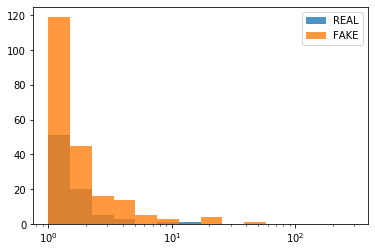

In [266]:
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(df_train[df_train['label']=='REAL']['hashtag_count'],bins=bins,alpha=0.8)
plt.hist(df_train[df_train['label']=='FAKE']['hashtag_count'],bins=bins,alpha=0.8)
plt.legend(('REAL','FAKE'))
plt.show()

### mention_count

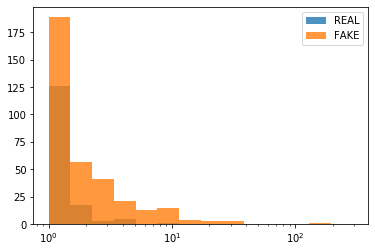

In [267]:
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(df_train[df_train['label']=='REAL']['mention_count'],bins=bins,alpha=0.8)
plt.hist(df_train[df_train['label']=='FAKE']['mention_count'],bins=bins,alpha=0.8)
plt.legend(('REAL','FAKE'))
plt.show()

## Correlation Matrix

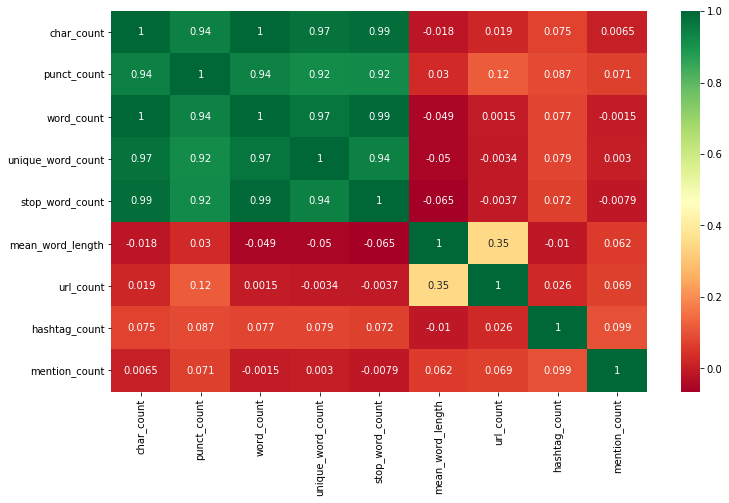

In [268]:
plt.figure(figsize=(12,7))
sns.heatmap(df_train.drop('Unnamed: 0', axis=1).corr(), annot=True, cmap='RdYlGn')
plt.show()

# Cosine Similarity

## Similarity between 'REAL'

In [44]:
nlp = spacy.load('en_core_web_lg')

In [45]:
# We create a dataframe with the text labeled 'REAL'
df_real = df_train[df_train['label'] == 'REAL']

In [46]:
#We create a dataframe with the text labeled 'FAKE'
df_fake = df_train[df_train['label'] == 'FAKE']

In [48]:
print(df_train['label'].value_counts())
print(len(df_fake))
print(len(df_real))

REAL    2847
FAKE    2827
Name: label, dtype: int64
2827
2847


In [49]:
a = nlp(df_real.iloc[0].loc['text'])

In [50]:
b = nlp(df_real.iloc[1].loc['text'])

In [51]:
c = nlp(df_fake.iloc[0].loc['text'])

In [52]:
# High similarity between 2 texts labeled 'REAL'
a.similarity(b)

0.9771196580016692

In [53]:
# High similarity between one 'REAL' and one 'FAKE' text
a.similarity(c)

0.9778839166531763

In [54]:
# We define a function that convert each text into a spacy document
def simz(text):
    text = nlp(text)
    return text

In [1]:
# We apply the function on the dataframe
df_real['nlp'] = df_real['text'].apply(simz)

In [0]:
# We create a similarity list between text labeled 'REAL'
real_similarity = []

for i in df_real['nlp']:
    for j in df_real['nlp']:
        if i != j:
            real_similarity.append(i.similarity(j))

In [0]:
len(real_similarity)

8102562

In [0]:
# Similarity mean between text labeled 'REAL'
avg = mean(real_similarity)
print("The average is ", round(avg,3))

The average is  0.958


## Similarity between 'FAKE'

In [2]:
#apply function
df_fake['nlp'] = df_fake['text'].apply(simz)

In [3]:
#list de similarity de tous les text real entre eux
fake_similarity = []

for i in df_fake['nlp']:
    for j in df_fake['nlp']:
        if i != j:
            fake_similarity.append(i.similarity(j))

In [0]:
len(fake_similarity)

7989102

In [0]:
# Similarity mean between text labeled 'FAKE'
from statistics import mean

avg1 = mean(fake_similarity)
print("The average is ", round(avg1,3))

The average is  0.937


## Similarity between 'REAL' and 'FAKE' 

In [4]:
#list de similarity de tous les text real entre eux
real_fake_similarity = []

for i in df_real['nlp']:
    for j in df_fake['nlp']:
        real_fake_similarity.append(i.similarity(j))

In [0]:
len(real_fake_similarity)

8048469

In [0]:
#moyenne de similarity entre les text real entre eux
avg2 = mean(real_fake_similarity)
print("The average is ", round(avg1,3))

The average is  0.945


>**Final results:** <br>
Real Similarity = 0.958 <br>
Fake Similarity = 0.937 <br>
Between Real & Fake Similarity = 0.945

# Topic Modeling with Latent Dirichlet Allocation

## Label 'TRUE'

### Preprocessing

In [269]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english') # each word have to occur in min 2 doc

In [270]:
dtm = cv.fit_transform(df_train[df_train.label == 'REAL']['text'])

In [271]:
dtm

<2847x26597 sparse matrix of type '<class 'numpy.int64'>'
	with 829618 stored elements in Compressed Sparse Row format>

### LDA

In [272]:
LDA = LatentDirichletAllocation(n_components=2, random_state=42) # number of topics

In [273]:
LDA.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=2, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

### Showing Top Words per topic

In [274]:
for index, topic in enumerate(LDA.components_):
    print(f'The Top 15 words for topic #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

The Top 15 words for topic #0
['cruz', 'presidential', 'democratic', 'state', 'voters', 'people', 'president', 'sanders', 'new', 'party', 'republican', 'campaign', 'said', 'clinton', 'trump']


The Top 15 words for topic #1
['time', 'house', 'court', 'new', 'law', 'iran', 'states', 'year', 'police', 'government', 'president', 'people', 'state', 'obama', 'said']




## Label 'FAKE'

### Preprocessing

In [275]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english') # each word have to occur in min 2 doc

In [276]:
dtm = cv.fit_transform(df_train[df_train.label == 'REAL']['text'])

In [277]:
dtm

<2847x26597 sparse matrix of type '<class 'numpy.int64'>'
	with 829618 stored elements in Compressed Sparse Row format>

### LDA

In [278]:
LDA = LatentDirichletAllocation(n_components=2, random_state=42) # number of topics

In [279]:
LDA.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=2, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

### Showing Top Words per topic

In [280]:
for index, topic in enumerate(LDA.components_):
    print(f'The Top 15 words for topic #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

The Top 15 words for topic #0
['cruz', 'presidential', 'democratic', 'state', 'voters', 'people', 'president', 'sanders', 'new', 'party', 'republican', 'campaign', 'said', 'clinton', 'trump']


The Top 15 words for topic #1
['time', 'house', 'court', 'new', 'law', 'iran', 'states', 'year', 'police', 'government', 'president', 'people', 'state', 'obama', 'said']




# Checking for missing values

In [283]:
# There are no missing values
df_train.isnull().sum()

Unnamed: 0           0
title                0
text                 0
label                0
char_count           0
punct_count          0
word_count           0
unique_word_count    0
stop_word_count      0
mean_word_length     0
url_count            0
hashtag_count        0
mention_count        0
dtype: int64

In [284]:
df_train.head()

,Unnamed: 0,title,text,label,char_count,punct_count,word_count,unique_word_count,stop_word_count,mean_word_length,url_count,hashtag_count,mention_count
1357,9957,"American Dream, Revisited",Will Trump pull a Brexit times ten? What would...,FAKE,7447,193,1195,635,492,5.231799,0,0,1
2080,7596,Clintons Are Under Multiple FBI Investigations...,Clintons Are Under Multiple FBI Investigations...,FAKE,3085,46,507,289,214,5.071006,0,0,0
2718,8905,The FBI Can’t Actually Investigate a Candidate...,Dispatches from Eric Zuesse This piece is cros...,FAKE,19297,565,3210,1288,1419,5.011838,0,1,0
812,8752,Confirmed: Public overwhelmingly (10-to-1) say...,Print \n[Ed. – Every now and then the facade c...,FAKE,1191,25,200,144,70,4.940000,0,0,0
4886,7804,Nanny In Jail After Force Feeding Baby To Death,Nanny In Jail After Force Feeding Baby To Deat...,FAKE,1573,38,257,180,95,5.081712,0,0,0


# Text Classification

## Only with Numerical Features

### Split the data into train & valid sets

In [5]:
X = df_train._get_numeric_data().drop('Unnamed: 0', axis=1)
y = df_train.label

In [286]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [288]:
print(f'Training Data Shape: {X_train.shape}')
print(f'Testing Data Shape: {X_valid.shape}')

Training Data Shape: (3971, 9)
Testing Data Shape: (1703, 9)


### Train a Logistic Regression Classifier

In [289]:
lr_model = LogisticRegression(solver='lbfgs', random_state=42, max_iter=500)

lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Report the results

In [290]:
y_pred = lr_model.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))

[[584 258]
 [312 549]]


In [291]:
# ⚠️The label order is important for to correctly assign the confusion matrix
df_train.label.unique()

array(['FAKE', 'REAL'], dtype=object)

In [292]:
# You can make the confusion matrix less confusing by adding labels:
df_conf_mat = pd.DataFrame(confusion_matrix(y_valid,y_pred), index=['FAKE','REAL'], columns=['FAKE','REAL'])
display(df_conf_mat)

,FAKE,REAL
FAKE,584,258
REAL,312,549


In [293]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

        FAKE       0.65      0.69      0.67       842
        REAL       0.68      0.64      0.66       861

    accuracy                           0.67      1703
   macro avg       0.67      0.67      0.67      1703
weighted avg       0.67      0.67      0.67      1703



In [294]:
print(accuracy_score(y_valid, y_pred))

0.6652965355255431


### Train a Naive Bayes Classifier

In [295]:
nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Report the results

In [296]:
y_pred = nb_model.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))

[[679 163]
 [422 439]]


In [297]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

        FAKE       0.62      0.81      0.70       842
        REAL       0.73      0.51      0.60       861

    accuracy                           0.66      1703
   macro avg       0.67      0.66      0.65      1703
weighted avg       0.67      0.66      0.65      1703



In [298]:
print(accuracy_score(y_valid, y_pred))

0.6564885496183206


### Train a Support Vector Machine (SVM) Classifier 

In [307]:
svc_model = SVC(gamma='auto', random_state=42)

svc_model.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

#### Report the results

In [308]:
y_pred = svc_model.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))

[[834   8]
 [784  77]]


In [309]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

        FAKE       0.52      0.99      0.68       842
        REAL       0.91      0.09      0.16       861

    accuracy                           0.53      1703
   macro avg       0.71      0.54      0.42      1703
weighted avg       0.71      0.53      0.42      1703



In [310]:
print(accuracy_score(y_valid, y_pred))

0.5349383440986495


## Feature Extraction from text

### Split the data into train & valid sets

In [4]:
df_train.head()

,Unnamed: 0,title,text,label
1357,9957,"American Dream, Revisited",Will Trump pull a Brexit times ten? What would...,FAKE
2080,7596,Clintons Are Under Multiple FBI Investigations...,Clintons Are Under Multiple FBI Investigations...,FAKE
2718,8905,The FBI Can’t Actually Investigate a Candidate...,Dispatches from Eric Zuesse This piece is cros...,FAKE
812,8752,Confirmed: Public overwhelmingly (10-to-1) say...,Print \n[Ed. – Every now and then the facade c...,FAKE
4886,7804,Nanny In Jail After Force Feeding Baby To Death,Nanny In Jail After Force Feeding Baby To Deat...,FAKE


In [311]:
X = df_train.text
y = df_train.label

In [312]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [313]:
print(f'Training Data Shape: {X_train.shape}')
print(f'Testing Data Shape: {X_valid.shape}')

Training Data Shape: (3971,)
Testing Data Shape: (1703,)


### Train a Logistic Regression Classifier

In [314]:
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(X_train) 
X_valid_tfidf = tfidf.transform(X_valid)

In [315]:
X_train_tfidf.shape

(3971, 55640)

In [316]:
# 1st text X_train, word ID, tfidf score
print(X_train_tfidf)

  (0, 19257)	0.01283726062007641
  (0, 3814)	0.024468805913925976
  (0, 35504)	0.010673110772236483
  (0, 38146)	0.018260946895869618
  (0, 7755)	0.03425712453165526
  (0, 40644)	0.03802452328501216
  (0, 50407)	0.05986719337460776
  (0, 47515)	0.05348407327162572
  (0, 45737)	0.05986719337460776
  (0, 49789)	0.007249029839134223
  (0, 46536)	0.05221397377820609
  (0, 20738)	0.05986719337460776
  (0, 13836)	0.039928355900539544
  (0, 4283)	0.05348407327162572
  (0, 30004)	0.05114011995750755
  (0, 54575)	0.05274527705890672
  (0, 33166)	0.035615967399534224
  (0, 50128)	0.02891852658209403
  (0, 1981)	0.05986719337460776
  (0, 52817)	0.05986719337460776
  (0, 12904)	0.036779709702064865
  (0, 97)	0.018068399795407756
  (0, 26562)	0.05986719337460776
  (0, 3411)	0.04583085367522404
  (0, 50135)	0.07871092773969554
  :	:
  (3970, 11415)	0.04316599946596808
  (3970, 44177)	0.01715245670548522
  (3970, 19257)	0.019080040419165174
  (3970, 35504)	0.015863461135471376
  (3970, 38146)	0.02714

In [317]:
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names())

In [318]:
tfidf_df.head()

,00,000,000000031,00000031,000035,00006,0001,0001pt,000billion,000ft,...,שתי,תאמצנה,תוצאה,תחל,תיירות,תנותק,תעודת,תתרכז,القادمون,عربي
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Each word is assigned to a word ID
tfidf.vocabulary_

In [320]:
tfidf.get_feature_names()[53557]

'we'

In [321]:
lr_model = LogisticRegression(solver='lbfgs', random_state=42)

lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Report the results

In [322]:
y_pred = lr_model.predict(X_valid_tfidf)
print(confusion_matrix(y_valid, y_pred))

[[786  56]
 [ 88 773]]


In [323]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

        FAKE       0.90      0.93      0.92       842
        REAL       0.93      0.90      0.91       861

    accuracy                           0.92      1703
   macro avg       0.92      0.92      0.92      1703
weighted avg       0.92      0.92      0.92      1703



In [324]:
print(accuracy_score(y_valid, y_pred))

0.9154433352906636


#### Using Logistic Regression coefficients

In [325]:
col_name = [i for i in tfidf_df.columns]
coef_value = [i for i in lr_model.coef_.tolist()[0]]

In [326]:
dico = dict(zip(col_name, coef_value))

In [335]:
# We print the 15 words with the highest absolute coef
sorted(dico.items(), key=lambda x: abs(x[1]), reverse=True)[:15]

[('said', 5.956685076831345),
 ('hillary', -3.784484261373626),
 ('2016', -3.652911552745588),
 ('october', -2.8557914384120235),
 ('he', 2.7595200295696585),
 ('but', 2.637393945195805),
 ('election', -2.556211681018725),
 ('that', 2.554334038576233),
 ('us', -2.5290072912043726),
 ('in', 2.525647921312758),
 ('sanders', 2.4454754812695594),
 ('fbi', -2.4095908977426452),
 ('his', 2.256222329877455),
 ('by', -2.2498468286456794),
 ('cruz', 2.196120062484507)]

### Train a Naive Bayes Classifier

In [338]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('nb_model', MultinomialNB())])

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('nb_model',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

#### Report the results

In [339]:
y_pred = text_clf.predict(X_valid)

In [340]:
print(confusion_matrix(y_valid, y_pred))

[[512 330]
 [  8 853]]


In [341]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

        FAKE       0.98      0.61      0.75       842
        REAL       0.72      0.99      0.83       861

    accuracy                           0.80      1703
   macro avg       0.85      0.80      0.79      1703
weighted avg       0.85      0.80      0.79      1703



In [342]:
print(accuracy_score(y_valid, y_pred))

0.8015267175572519


### Train a Linear SVC

In [343]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf', LinearSVC(random_state=42))])

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

#### Report the results

In [344]:
y_pred = text_clf.predict(X_valid)

In [345]:
print(confusion_matrix(y_valid, y_pred))

[[802  40]
 [ 61 800]]


In [346]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

        FAKE       0.93      0.95      0.94       842
        REAL       0.95      0.93      0.94       861

    accuracy                           0.94      1703
   macro avg       0.94      0.94      0.94      1703
weighted avg       0.94      0.94      0.94      1703



In [347]:
print(accuracy_score(y_valid, y_pred))

0.9406928948913682


## Prediction on the test set

In [348]:
X_test = df_test['text']
y_test = df_test['label']

### Fit our best model on all the train data

In [349]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf', LinearSVC(random_state=42))])

text_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

### Report the results

In [350]:
y_pred = text_clf.predict(X_test)

In [351]:
print(confusion_matrix(y_test, y_pred))

[[294  15]
 [ 23 301]]


In [352]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        FAKE       0.93      0.95      0.94       309
        REAL       0.95      0.93      0.94       324

    accuracy                           0.94       633
   macro avg       0.94      0.94      0.94       633
weighted avg       0.94      0.94      0.94       633



In [353]:
print(accuracy_score(y_test, y_pred))

0.9399684044233807


# Deep Learning

In [0]:
import torch
from torchtext import data
from torchtext import datasets
import random

SEED = 1234

#torch.manual_seed(SEED)


TEXT = data.Field(tokenize = 'spacy', batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

In [0]:
#defining tuples (le premier du tuple doit match notre nom de dataset tabulaire, le deuxieme doit match son field)
fields = [("Unnamed: 0",None),("title", None),("text", TEXT),("label", LABEL)]

In [0]:
#importer les donnees dependement de si on a train, valid, test ou bien juste train / test. Ici on a juste un fichier train, voir sentiment 1 pour multi fichier options (pas de .split apres TabularDataset)
train = data.TabularDataset(path = 'fake_or_real_news.csv',
                                format = 'csv',
                                fields = fields,
                                skip_header = True )

In [0]:
train_data, valid_data = train.split(split_ratio = 0.8, random_state = random.seed(SEED))

In [0]:
print(f'Training has {len(train_data)} observations \nValidation has {len(valid_data)} observations')

In [0]:
TEXT.build_vocab(train_data, 
                 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [0]:
BATCH_SIZE = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits((train_data, valid_data),
                                                    batch_sizes = (10,10),
                                                    device = device,
                                                    sort_key = lambda x: x.text,
                                                    sort_within_batch = True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [1,2,3]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [0]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

In [0]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data

In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'text_mining.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')